# Import the essentials

In [ ]:
import os
credentials = {"username":"muntahashams","key":"f9b104e85dd7a74eab8a876f8d5b9536"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]
!kaggle datasets download -d salmaneunus/railway-track-fault-detection
!unzip railway-track-fault-detection.zip

!kaggle datasets download -d madmaxliu/inceptionv3
!unzip inceptionv3.zip

100% 2.00G/2.00G [00:20<00:00, 48.6MB/s]
100% 2.00G/2.00G [00:20<00:00, 105MB/s] 
Archive:  railway-track-fault-detection.zip
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100159.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100209.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_101124.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_101200.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102203.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102222.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102819.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201114_103110.jpg  
  inflating: Railway Track fault Detection Updated/Test/Defective/IMG_20201211_121712.jpg  
  inflating: Railway Track fault Detection Upd

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3


# Loading Data 

In [2]:
train_dir = os.path.join('/content/Railway Track fault Detection Updated/Train')
validation_dir = os.path.join('/content/Railway Track fault Detection Updated/Validation')

# Directory with our training defective/nondefective pictures
train_defective_dir = os.path.join('/content/Railway Track fault Detection Updated/Train/Defective')
train_nondefective_dir = os.path.join('/content/Railway Track fault Detection Updated/Train/Non defective')

# Directory with our validation defective/nondefective pictures
validation_defective_dir = os.path.join('/content/Railway Track fault Detection Updated/Validation/Defective')
validation_nondefective_dir = os.path.join('/content/Railway Track fault Detection Updated/Validation/Non defective')

In [3]:
train_defective_fnames = os.listdir(train_defective_dir )
train_nondefective_fnames = os.listdir( train_nondefective_dir)

print(train_defective_fnames[:20])
print(train_nondefective_fnames[:20])

['89e8b1a9ca8c41919021f8f4faaf37f0.jpg', 'IMG_20201114_101614.jpg', 'IMG_20201114_103059.jpg', 'IMG_20201114_102058.jpg', 'IMG_20201114_101952.jpg', 'IMG_20201114_101138.jpg', 'IMG_20201114_101930.jpg', 'IMG_20201114_102936.jpg', 'dbb9223f7e652986a00c0dd8d8f1ccf8.jpg', '131348023_405054987354853_8834671660058234194_n.jpg', 'IMG_20201211_113654.jpg', 'azer2003120026fbtr.jpg', '131275810_2686956714949012_5021348409242545922_n.jpg', 'IMG_20201211_112859.jpg', 'IMG_20201211_113410.jpg', 'IMG_20201114_101537.jpg', 'IMG_20201211_112951.jpg', '131092897_149705809860659_8798464983059531038_n.jpg', 'IMG_20201114_102022.jpg', 'IMG_20201211_112817.jpg']
['IMG_20201114_100248.jpg', 'IMG_20201114_100805.jpg', 'IMG_20201114_102441.jpg', 'IMG_20201114_102429.jpg', 'IMG_20201114_100140.jpg', 'IMG_20201114_102353.jpg', 'IMG_20201114_102847.jpg', 'IMG_20201114_102703.jpg', 'IMG_20201114_102912.jpg', 'IMG_20201114_101519.jpg', 'IMG_20201114_102404.jpg', 'IMG_20201114_100139.jpg', 'IMG_20201114_103055.jpg

In [4]:
print('total training defective images :', len(os.listdir(train_defective_dir)))
print('total training non-defective images :', len(os.listdir(train_nondefective_dir)))


print('total validation defective images :', len(os.listdir( validation_defective_dir ) ))
print('total validation non-defective images :', len(os.listdir( validation_nondefective_dir) ))

total training defective images : 150
total training non-defective images : 150
total validation defective images : 31
total validation non-defective images : 31


In [5]:
# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# **DATA VISUALIZATION**

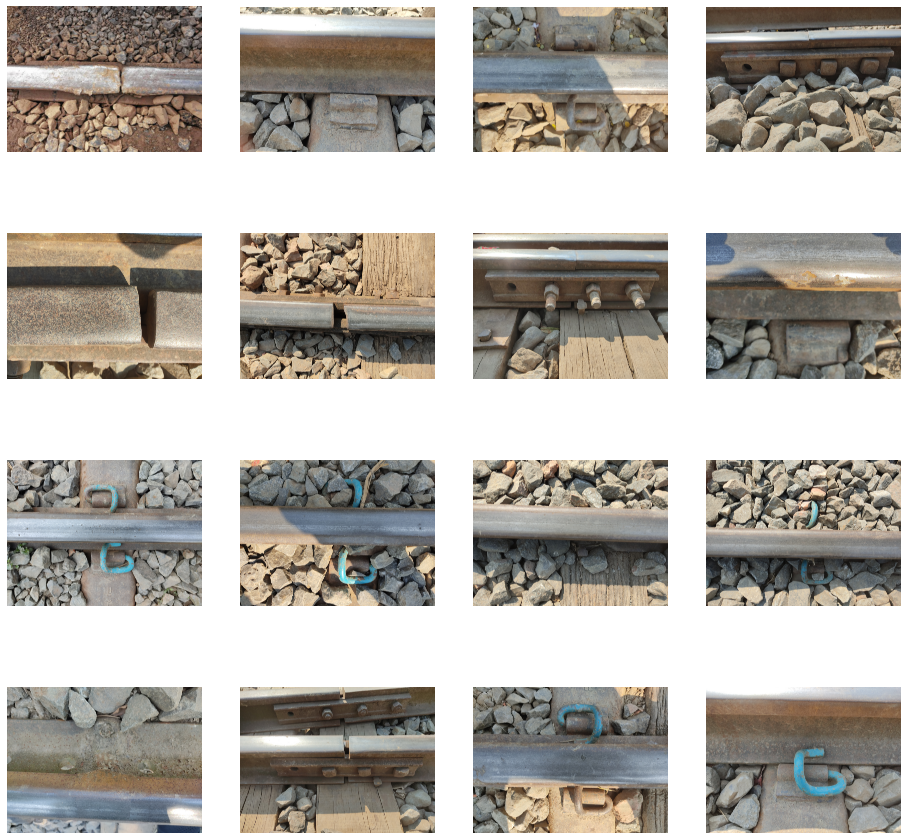

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_defective_dir, fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_nondefective_dir, fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# PRE-TRAINED MODEL

In [8]:
local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (300,300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

#**DATA** **PREPROCESSING**


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300,300))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (300,300))

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [20]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(32, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'Adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=25,                            
                              verbose=2)

Epoch 1/25
15/15 - 79s - loss: 2.2540 - accuracy: 0.4950 - val_loss: 1.4844 - val_accuracy: 0.5161
Epoch 2/25
15/15 - 71s - loss: 0.7696 - accuracy: 0.6421 - val_loss: 0.7124 - val_accuracy: 0.5323
Epoch 3/25
15/15 - 71s - loss: 0.6811 - accuracy: 0.6054 - val_loss: 0.6110 - val_accuracy: 0.7258
Epoch 4/25
15/15 - 71s - loss: 0.6645 - accuracy: 0.6555 - val_loss: 0.5318 - val_accuracy: 0.6452
Epoch 5/25
15/15 - 71s - loss: 0.5472 - accuracy: 0.7124 - val_loss: 0.4268 - val_accuracy: 0.8226
Epoch 6/25
15/15 - 71s - loss: 0.4753 - accuracy: 0.7659 - val_loss: 0.3965 - val_accuracy: 0.7903
Epoch 7/25
15/15 - 71s - loss: 0.4796 - accuracy: 0.7391 - val_loss: 0.5474 - val_accuracy: 0.7097
Epoch 8/25
15/15 - 71s - loss: 0.4861 - accuracy: 0.7659 - val_loss: 0.4516 - val_accuracy: 0.8226
Epoch 9/25
15/15 - 71s - loss: 0.4836 - accuracy: 0.7993 - val_loss: 0.4348 - val_accuracy: 0.8065
Epoch 10/25
15/15 - 71s - loss: 0.3622 - accuracy: 0.8161 - val_loss: 0.3806 - val_accuracy: 0.8065
Epoch 11/

In [28]:
model_save_name=model.save('mymodel.h5',history)
print('model save successfully')

model save successfully


Text(0.5, 1.0, 'Training and validation loss')

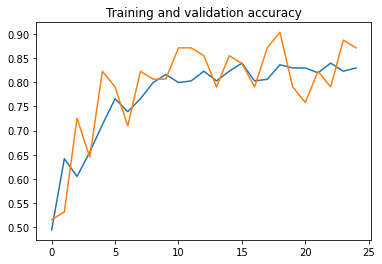

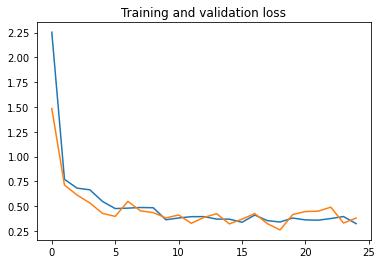

In [23]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

[[0.]]
This Railway track has fault


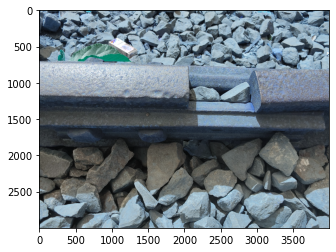

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_102203.jpg')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

[[8.732682e-22]]
This Railway track has fault


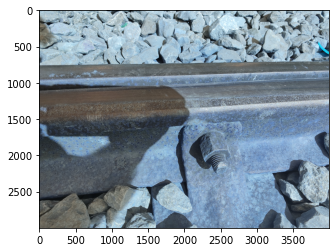

In [25]:
img = cv2.imread('/content/Railway Track fault Detection Updated/Test/Non defective/IMG_20201114_101907.jpg')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")